In [1]:
# import cv2
import numpy as np
# from tqdm import tqdm # progress bar for loops
import os
import tensorflow as tf

DATASET_FOLER = "chest_xray_pneumonia_dataset"
TRAINING_FOLER = DATASET_FOLER + "/" + "train"
TESTING_FOLER = DATASET_FOLER + "/" + "test"
IMAGE_HEIGHT=150
IMAGE_WIDTH=150
COLOR_MODE='rgb'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
PATIENCE = 25
EPOCHS = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    batch_size=32,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='training',
    validation_split=0.2,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    subset='validation',
    validation_split=0.2,
    seed=42,
)



['NORMAL', 'PNEUMONIA']
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


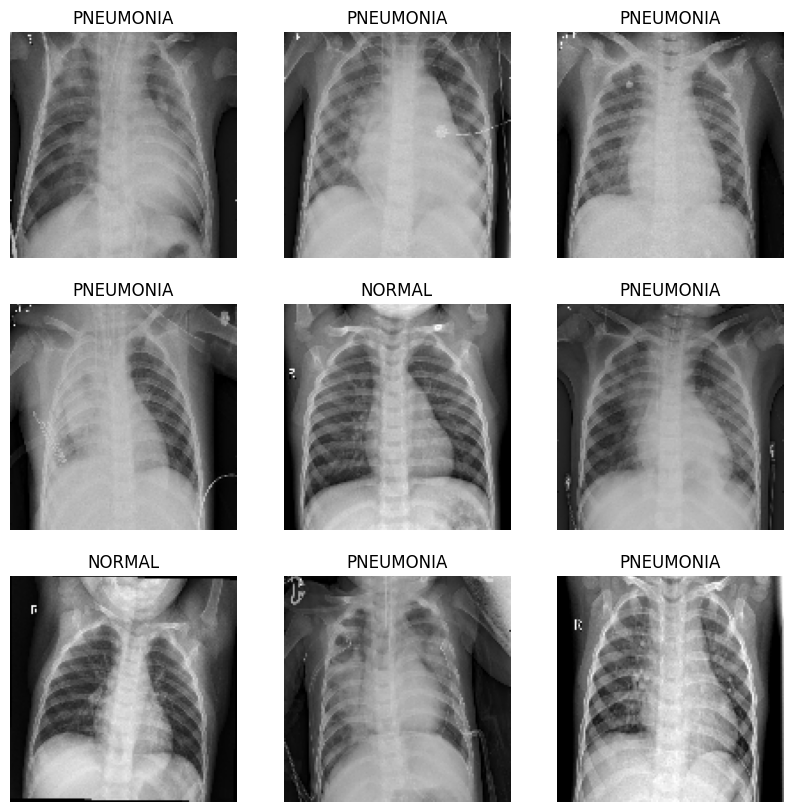

In [ ]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow import keras

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

    preprocessing,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    # keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    # # keras.layers.BatchNormalization(momentum=0.87),
    # keras.layers.MaxPooling2D(),

    # keras.layers.GlobalAveragePooling2D(),

    # keras.layers.Dropout(0.2),

    keras.layers.Dense(1, activation="sigmoid"), #sigmoid is for binary classification
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 128, 128, 3)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing_1 (Resizing)     (None, 128, 128, 3)       0         |
|                                                               |
| rescaling_1 (Rescaling)   (None, 128, 128, 3)       0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                     

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
)

Epoch 1/100
131/131 [==============================] - 21s 124ms/step - loss: 0.5721 - binary_accuracy: 0.7376 - val_loss: 0.5326 - val_binary_accuracy: 0.7344
Epoch 2/100
131/131 [==============================] - 12s 95ms/step - loss: 0.4569 - binary_accuracy: 0.7697 - val_loss: 0.4566 - val_binary_accuracy: 0.8447
Epoch 3/100
131/131 [==============================] - 12s 95ms/step - loss: 0.3283 - binary_accuracy: 0.8675 - val_loss: 0.2920 - val_binary_accuracy: 0.8830
Epoch 4/100
131/131 [==============================] - 12s 95ms/step - loss: 0.2462 - binary_accuracy: 0.9003 - val_loss: 0.2079 - val_binary_accuracy: 0.9243
Epoch 5/100
131/131 [==============================] - 12s 95ms/step - loss: 0.1880 - binary_accuracy: 0.9291 - val_loss: 0.1889 - val_binary_accuracy: 0.9262
Epoch 6/100
131/131 [==============================] - 13s 96ms/step - loss: 0.1589 - binary_accuracy: 0.9360 - val_loss: 0.1857 - val_binary_accuracy: 0.9185
Epoch 7/100
131/131 [========================

Epochs run: 59


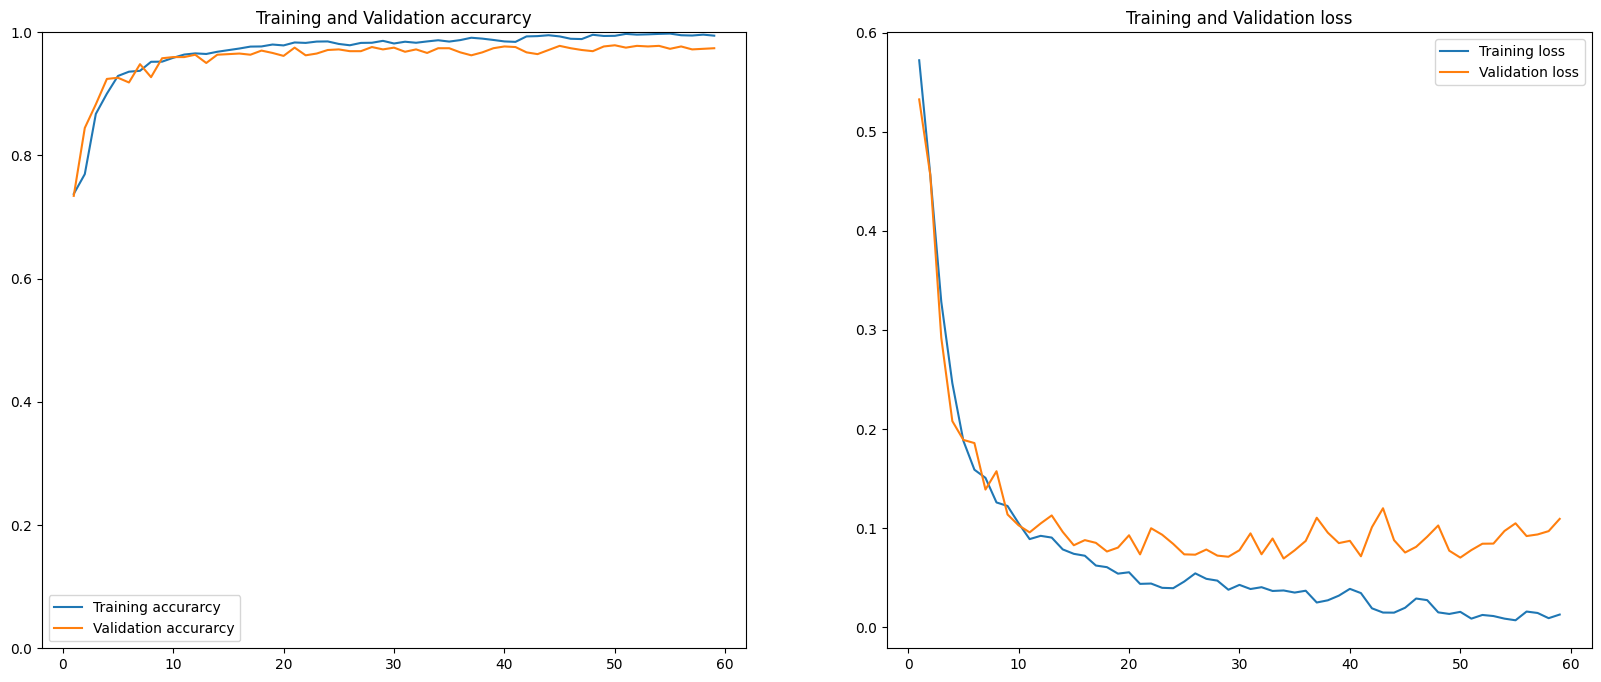

In [ ]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["binary_accuracy"]
val_acc = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(TESTING_FOLER,color_mode=COLOR_MODE)

y_pred = model.evaluate(test_ds, verbose=0)
prediction = model.predict(test_ds)

print("Test accuracy:", y_pred[1]*100)
print("Test loss:", y_pred[0]*100)

Found 624 files belonging to 2 classes.
20/20 [==============================] - 1s 44ms/step
Test accuracy: 68.2692289352417
Test loss: 197.95953035354614


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define your validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TESTING_FOLER,
    image_size=(128, 128),
    batch_size=32)

# Get true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Iterate over the validation dataset
for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_probabilities.extend(predictions)

# Convert probabilities to predicted labels
predicted_labels = np.where(np.array(predicted_probabilities) > 0.5, 1, 0)

# Convert true labels and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Build the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'validation_dir' is not defined

Found 624 files belonging to 2 classes.
1/1 [==============================] - 0s 25ms/step
[[0.4935998 ]
 [0.88993806]
 [0.998796  ]
 [1.        ]
 [1.        ]
 [0.99999297]
 [0.9999101 ]
 [0.99999976]
 [0.99999964]
 [0.99995685]
 [0.9999993 ]
 [0.99999785]
 [0.99807596]
 [0.9995826 ]
 [0.9648085 ]
 [0.9999957 ]
 [0.9999999 ]
 [1.        ]
 [0.9997507 ]
 [0.99999976]
 [0.9842184 ]
 [1.        ]
 [0.9999831 ]
 [0.9963206 ]
 [1.        ]
 [1.        ]
 [0.9258613 ]
 [0.5452817 ]
 [1.        ]
 [0.9766094 ]
 [0.9999442 ]
 [0.00676838]]
1/1 [==============================] - 0s 23ms/step
[[0.999775  ]
 [0.9999994 ]
 [0.99859875]
 [0.9999951 ]
 [0.9999987 ]
 [0.9998209 ]
 [0.999961  ]
 [0.09436085]
 [0.93658096]
 [1.        ]
 [0.9999349 ]
 [0.99990904]
 [0.024551  ]
 [0.980117  ]
 [0.99999726]
 [0.9952865 ]
 [0.9999994 ]
 [0.98500675]
 [0.7891278 ]
 [1.        ]
 [0.99999976]
 [0.99999905]
 [0.9272428 ]
 [1.        ]
 [1.        ]
 [0.9999994 ]
 [0.9999989 ]
 [0.9996007 ]
 [0.98694533]
 

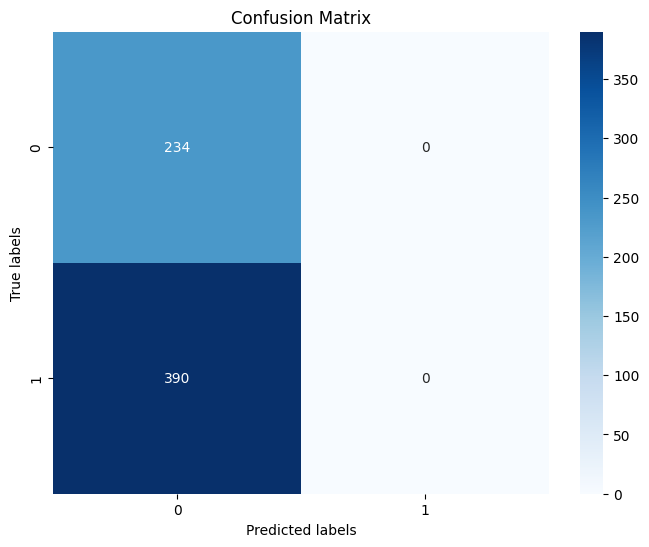

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# testData = tf.keras.preprocessing.image_dataset_from_directory(
#     TESTING_FOLER, 
#     color_mode=COLOR_MODE,
#     shuffle=False,
#     class_mode='binary',
#     # labels='inferred',
#     # image_size=(128,128),
#     # batch_size=32
# )


# Create a TensorFlow dataset from the validation directory
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TESTING_FOLER,
    image_size=(128, 128),
    batch_size=32
)
# Get true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    print(predictions)
    predicted_probabilities.extend(predictions)

print(predicted_probabilities)
# Get predicted labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Build the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# SAVING THE MODEL

# save the iris classification model
model.save("pneumonia-cnn.h5")

In [ ]:
import tensorflow as tf

model.save("bt-cnn.h5") 
loaded_model = tf.keras.models.load_model("pneumonia-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 


20/20 [==============================] - 1s 41ms/step - loss: 1.9796 - binary_accuracy: 0.6827
